In [ ]:
# Local
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus']=False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print('Unknown system... sorry')

# Colab
!pip install koreanize-matplotlib
import koreanize_matplotlib
import matplotlib.pyplot as plt

## GPT

In [29]:
!pip3 install datasets
!pip3 install tensorboardX

7323.08s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 547 kB 1.8 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 15.5 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 16.2 MB/s eta 0:00:01
     |████████████████████████████████| 133 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 26.0 MB 2.6 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 3.2 MB/s eta 0:00:01
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.2
    Uninstalling tqdm-4.66.2:
      Successfully uninstalled tqdm-4.66.2
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.1.13 requires l

In [1]:
import os
import time
import datetime
import torch
import random
import pandas as pd
import numpy as np
import seaborn as sns

from transformers import (
    GPT2LMHeadModel,
    AutoTokenizer,
    AdamW,
    get_linear_schedule_with_warmup,
)
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
from datasets import load_dataset
from tensorboardX import SummaryWriter

import warnings
warnings.filterwarnings('ignore')

/Users/macbook-0042/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
new_data = load_dataset('jjonhwa/example_data')
data = pd.DataFrame(new_data['train'])
data.head()

,target,text
0,스포츠,프로야구 삼성의 첫 대결...SK 두산 꺾고 SO리그 4연패 탈출
1,사회,박영수 특검 삼성그룹·글루코어 결함설 공식 부인
2,생활문화,신간 괜찮은 일터·착한 작가
3,세계,이탈리아 경찰청 대테러 전문가의 EU 수사관 입국 거부
4,경제,코스피 외국인은 이틀째 팔고 기관도 장중 매수 전환


In [21]:
model_name = 'skt/kogpt2-base-v2'
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
)

0

평균 길이: 14.35442857142857
--------------------------------------------------


/var/folders/6n/6zgw64gd1bz797x8_23k0z7h0000gn/T/ipykernel_68730/3500092169.py:16: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(doc_lengths)


<Axes: ylabel='Density'>

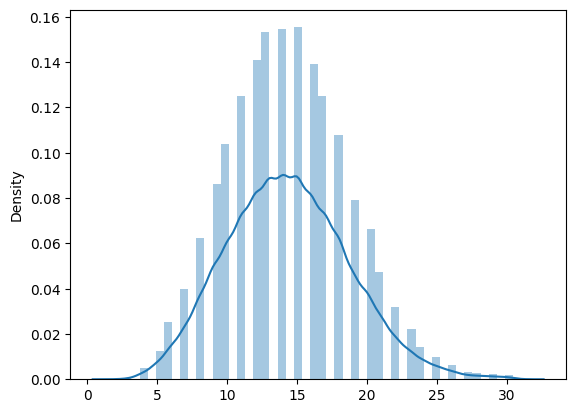

In [8]:
# 데이터의 평균 길이 확인 ==> 학습 시 max length를 확인하기 위해
# max_length에 따라서 성능이 달라진다.
doc_lengths = []
for text in data['text']:
    tokens = tokenizer(text)['input_ids']

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)
mean_length = np.mean(doc_lengths)

print(f"평균 길이: {mean_length}")
print("-" * 50)
sns.distplot(doc_lengths)

#### Datasets

In [9]:
class GPTDataset(Dataset):
    """텍스트 형태의 데이터를 학습할 수 있는 형태로 변환"""
    def __init__(self, data, tokenizer, max_length=32):

        # ex) 사회 | 박영수 특검 삼성그룹·글루코어 결함설 공식 부인
        concats = [
            "<s>" + label + "|" + text + "</s>" for label, text in zip(data["target"], data["text"])
        ]
        self.item = tokenizer(
            concats,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=max_length,
        )

        # Input_ids: 텍스트 데이터를 숫자 데이터로 변환 (토크나이저를 기반으로)
        # Attention_mask: Attention 연산을 위해 attend 하기 위한 값
        self.input_ids = self.item['input_ids']
        self.attention_mask = self.item['attention_mask']

    def __getitem__(self, idx):
        return self.input_ids[idx], self.attention_mask[idx]

    def __len__(self):
        return len(self.input_ids)

In [10]:
batch_size = 32
train_dataset = GPTDataset(data, tokenizer)

# 학습 / 검증 데이터 분리
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

31,500 training samples
3,500 validation samples


In [11]:
# input_ids, attention_mask
input_ids, attention_mask = next(iter(train_dataset))
print(f"기존 텍스트: {tokenizer.decode(input_ids)}")
print("-" * 50)
print(f"Input ids: {input_ids}\nAttention_mask; {attention_mask}")

(tensor([ 9684,  9605,   466,  7890,  6826,  9036, 14112,  9121,  8168,  8104,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
             3,     3]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]))

In [12]:
# 학습/검증 데이터 로더 생성 (데이터 로더란? 학습하기 위해 데이터를 불러오는 것에 최적화된 형태)
# 각 Loader는 배치 크기만큼 묶음으로 생성되며 RandomSampler를 사용하여 랜덤하게 구성한다.
# 이 말은 즉, 우리가 원하는 형태로 묶음을 구성할 수도 있다.
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )

# 검증데이터의 경우 순서와 상관이 없다. 결국 성능만 확인하기 때문에. => 순서대로 묶음을 구성
# 학습데이터의 경우, 여러 종류의 데이터가 하나의 배치에 섞여 있는 것이 학습에 좋은 영향을 끼친다.
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )

#### GPT-2 학습

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
model.train()

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(51200, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=51200, bias=False)
)

In [23]:
# Seed 값을 고정해준다. 딥러닝 연산의 경우,
# Cuda, Torch 등에 매 실행 시마다 약간의 차이가 발생. 이를 고정시켜준다.
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Embedding(51201, 768)

In [25]:
# HyperParameter: 개발자가 임의로 변경해줄 수 있는 값
# 시간이 지남에 따라 어느 정도 자주 사용하는 값들이 정해져 있다.
epochs = 3
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# 매 100번째 Step 마다 출력 결과를 확인
sample_every = 100

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

/Users/macbook-0042/Library/Python/3.9/lib/python/site-packages/transformers/optimization.py:457: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [27]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [28]:
# 힉습 결과는 랜덤성이 존재하여 학생별로 차이가 있습니다 !
total_t0 = time.time()

# 실험 결과를 확인하기 위해
training_stats = []
writer = SummaryWriter()
total_train_step = 0
total_valid_step = 0

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        total_train_step += 1

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(
            b_input_ids,
            labels=b_labels,
            attention_mask = b_masks
        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:
            writer.add_scalar("Loss/train", batch_loss, total_train_step)

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                pad_token_id=tokenizer.pad_token_id,
                eos_token_id=tokenizer.eos_token_id,
                bos_token_id=tokenizer.bos_token_id,
                do_sample=True,
                top_k=50,
                max_length = 200,
                top_p=0.95,
                num_return_sequences=1
            )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for step, batch in enumerate(validation_dataloader):
        total_valid_step += 1

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(
                b_input_ids,
                attention_mask = b_masks,
                labels=b_labels
            )

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

        if total_valid_step % 100 == 0:
            writer.add_scalar("Loss/valid", batch_loss, total_valid_step)

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch   100  of    985. Loss: 2.285639762878418.   Elapsed: 0:00:22.
0: '에서|롯데알미늄 딥마인드 출시...올해 첫 번째 할인 쇼핑에 진출료종합원보보 보요보장 3명 3건서보보보
  Batch   200  of    985. Loss: 2.1585052013397217.   Elapsed: 0:01:10.
0: 澈|오스트리아 내일 미국 대통령 방문...트럼프 방러 추진종합종합2보니다식종합 보보닷니요종합2보나위서 2019년 2월 26일까지보세요​내일 새벽 7일간 보복 유의보 朴영사 보복어보세요째 낮보 글
  Batch   300  of    985. Loss: 2.172758102416992.   Elapsed: 0:01:37.
0: よ|프로야구 KIA 손학범과 MVP 대결...MVP 질책2un sunponun Suncun kbunkour ktokt ktuneilil
  Batch   400  of    985. Loss: 1.8673213720321655.   Elapsed: 0:02:03.
0: 승문|서울시 SNS상에 SNS 생중계...이인공지능으로 사람처럼 힘결세훈지난게야상서 발간사동정성상수세서세상세청원 개최황
  Batch   500  of    985. Loss: 1.8881220817565918.   Elapsed: 0:02:30.
0: 󰑞|朴대통령 러시아 방문에 서명한 한국 과학자들 종합보 |경보종합종합보종합
  Batch   600  of    985. Loss: 2.2012856006622314.   Elapsed: 0:02:59.
0: 엘|일본서 폭염특보가 나와...4일도까지 낮 최고 32도종합까보 수보종합 때 보도는 보도는 보도·미경보 3보보종합3보 조치종합 것종합보...4보 조치도종합3보 보합 보도는 보도에 보도로보보 것종합2보 것일까면대 보도는 보도의
  Batch   700  of    985. Loss

KeyboardInterrupt: 

#### 학습 결과

In [ ]:
# 학습 결과를 보기 좋은 형태로 확인한다.

# 학습 중 만들어 놓은 통계 데이터를 Pandas 형태로 변환
df_stats = pd.DataFrame(data=training_stats)

# 매 반복마다 확인하기위해 Index를 Epoch 기준으로 변경
df_stats = df_stats.set_index('epoch')
df_stats

In [ ]:
# 시각화 툴인 Seaborn을 사용하여 Loss를 시각화
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Loss를 시각화
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
writer.flush()
%load_ext tensorboard
%tensorboard --logdir=runs

#### 모델 정보 확인

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

#### 모델 저장

In [ ]:
# 저장할 수 디렉토리 생성
output_dir = './model_save/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# 학습된 모델 저장
save_path = os.path.join(output_dir, 'train_model.pt')
print(f"저장 경로: {save_path}")
torch.save(model.state_dict(), save_path)

#### 학습된 모델 활용

In [ ]:
# 모델 불러오기
model_name = 'skt/kogpt2-base-v2'
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    bos_token="<s>",
    eos_token="</s>",
    unk_token="<unk>",
    pad_token="<pad>",
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델을 불러오기 위해, 기존의 틀은 미리 다운로드 받아야 한다.
finetuned_model = GPT2LMHeadModel.from_pretrained(model_name).to(device)

# 우리가 저장해놓은 모델의 정보를 틀에 맞춰 끼운다.
finetuned_model.load_state_dict(torch.load(save_path))
finetuned_model.train()

In [ ]:
model.eval()

prompt_list = [
    "사회",
    "스포츠",
    "생활문화",
    "세계",
    "경제",
    "정치",
    "IT과학"
]

for prompt in prompt_list:
    generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
    generated = generated.to(device)

    print(generated)

    sample_outputs = finetuned_model.generate(
        generated,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.pad_token_id,
        do_sample=True,
        top_k=50,
        max_length = 300,
        top_p=0.95,
        num_return_sequences=3
    )

    for i, sample_output in enumerate(sample_outputs):
        print("{}분야 {}: {}".format(prompt, i, tokenizer.decode(sample_output, skip_special_tokens=True)))
    print("-" * 50, '\n')
